In [212]:
import numpy as np
import pandas as pd
import os  
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import io
import dateutil
import collections
import time
from datetime import datetime
import wrds
import networkx as nx
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
%matplotlib inline

wrds is the package for the Wharton Database. wrds.Connection() connects to the database and is needed for each command

In [135]:
db = wrds.Connection()

Enter your WRDS username [ahardy12]:ahardy12
Enter your password:········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


list_libraries() list all libraries that can be connected to from the wrds package in python

In [3]:
list_libraries = db.list_libraries()
list_libraries[:10]

['public',
 'wrds_lib_internal',
 'centris',
 'ginsight',
 'gsi',
 'rent',
 'wrdsapps',
 'ims_obp_trial',
 'ginsight_basic',
 'ginsight_common']

The library needed is comp and the table within that library is funda. This represents the North America Fundamentals Annuals within Compustat Capital IQ.

Comp.Funda Variables:

AT -- Assets - Total                BKVLPS -- Book Value Per Share

COGS -- Cost of Goods Sold           DVT -- Dividends - Total

IB -- Income Before Extraordinary Items    LT -- Liabilities - Total

NI -- Net Income (Loss)             REVT -- Revenue - Total        SALE -- Sales/Turnover (Net)

SEQ -- Stockholders' Equity - Total  


In [142]:
Full_db = db.raw_sql("select gvkey,fyear,tic,conm,at,bkvlps,cogs,dvt,ib,lt,ni,revt,sale,seq from comp.funda where gvkey='008446' OR gvkey='005073' OR gvkey='009563' OR gvkey='006066' OR gvkey='006307' OR gvkey='006135' OR gvkey='005047' OR gvkey='006765' OR gvkey='004839' OR gvkey='007811' OR gvkey='003022' OR gvkey='001581' OR gvkey='0023978' OR gvkey='007155' OR gvkey='0010983' OR gvkey='001481' OR gvkey='008549' OR gvkey='004961' OR gvkey='0011259' OR gvkey='002285' OR gvkey='0063919' OR gvkey='007585' OR gvkey='005606' OR gvkey='0017828' OR gvkey='0062599' OR gvkey='003282' OR gvkey='005680' OR gvkey='007171' OR gvkey='002751' OR gvkey='0031673' OR gvkey='002136' OR gvkey='009899' OR gvkey='0010984' OR gvkey='003813' OR gvkey='002991' OR gvkey='0012384' OR gvkey='0030067' OR gvkey='0064768' OR gvkey='00125595' OR gvkey='00266315' OR gvkey='0029099' OR gvkey='0015111' OR gvkey='00177943'  LIMIT 1000;" )

If a list can be used in the raw sql command then it may be possible to make the process more automated. Right now the raw sql string has to be typed by hand. It may be possible to do a function with GVkey as input and the rest generated automatically.

In [139]:
years = list(range(1982,2003))

In [266]:
DBfrom1982to2002 = Full_db[Full_db.fyear.isin(years)]
DBfrom1982to2002.shape

(341, 14)

In [267]:
DBfrom1982to2002nonans = DBfrom1982to2002.dropna(axis=0, how='any')

In [271]:
DBfrom1982to2002nonans = DBfrom1982to2002nonans.reset_index(drop=True)

In [272]:
DBfrom1982to2002nonans.index

RangeIndex(start=0, stop=284, step=1)

In [273]:
features = ['at', 'bkvlps', 'cogs', 'dvt','ib','lt','ni','revt','sale','seq']
# Separating out the features
x = DBfrom1982to2002nonans.loc[:, features].values
# Standardizing the features
x = StandardScaler().fit_transform(x)

In [274]:
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['Principal Component 1', 'Principal Component 2'])

In [275]:
finalDf = pd.concat([principalDf, DBfrom1982to2002nonans[['conm']]], axis = 1)

In [276]:
companylist = set(DBfrom1982to2002nonans['conm'].tolist())

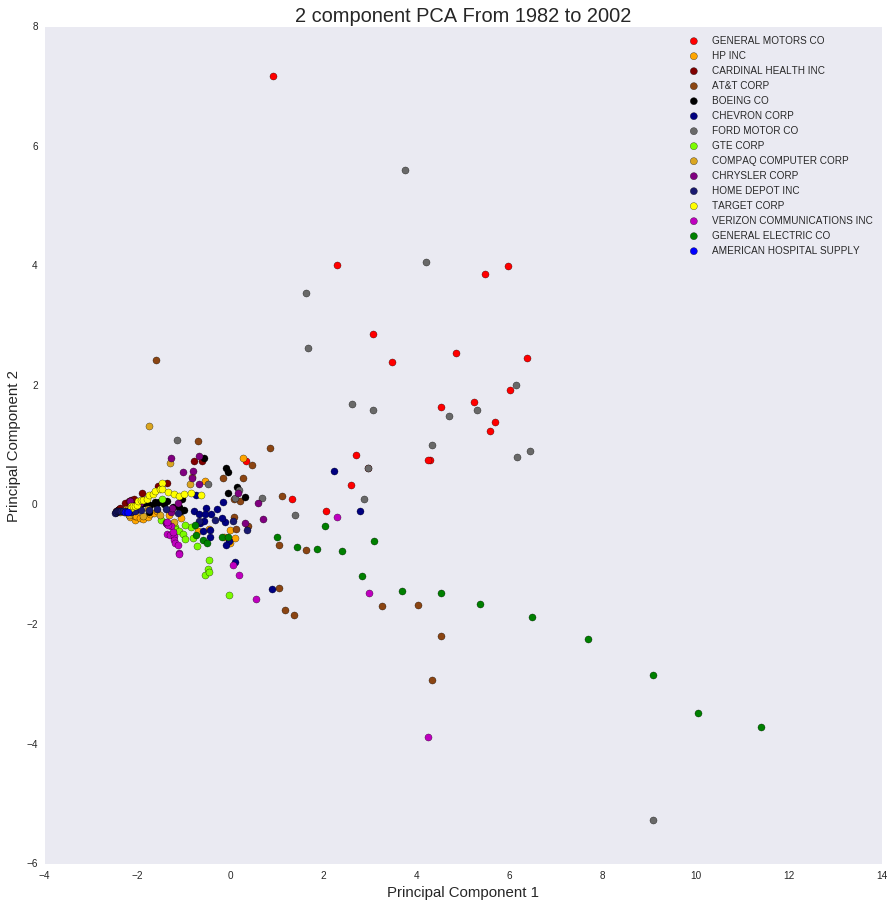

In [284]:
fig = plt.figure(figsize = (15,15))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA From 1982 to 2002', fontsize = 20)
companylist = set(DBfrom1982to2002nonans['conm'].tolist())
colors = ['r','orange','maroon', 'saddlebrown', 'k', 'navy', 'dimgrey', 'lawngreen', 'goldenrod', 'purple', 'midnightblue' , 'yellow', 'm', 'g', 'b']
for company, color in zip(companylist,colors):
    indicesToKeep = DBfrom1982to2002nonans['conm'] == company
    ax.scatter(finalDf.loc[indicesToKeep, 'Principal Component 1']
               , finalDf.loc[indicesToKeep, 'Principal Component 2']
               , c = color
               , s = 50)
ax.legend(companylist)
ax.grid()